In [1]:
# Importing Required Libraries 

# Dataframe Manipulation
import pandas as pd 
import numpy as np 

# Data Visualization
import matplotlib.pyplot as plt 
%matplotlib inline 
import seaborn as sn 

# Exploratory Data Analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.stattools import adfuller,kpss

# Modelling 
import tensorflow as tf
import pmdarima as pm

# Dealing with warnings 
import warnings
warnings.filterwarnings(action="ignore")

# Importing Data 
This section deals with importing the complete Nifty50 dataset which contains the valuations from 2000-2021 for more than 50 of the top Indian Multinational Corporations including Cipla, Reliance, Titan ect. We are only going to be dealing with `Wipro's` valuations, therefore we can perform some filtering to extract the required data.

In [2]:
# Importing Data 
nifty_all = pd.read_csv(r"C:\Users\Sidhant Mathur\Desktop\Nifty_Data\NIFTY50_all.csv")

# Retrieving Wipro stock data from the entire Nifty dataset
nifty_wipro = nifty_all[nifty_all["Symbol"]=="WIPRO"].reset_index()
nifty_wipro.drop('index',inplace=True,axis=1)

# Exploratory Data Analysis
Now that we have our data, let's familiarize ourselves with it. This section is going to dive deeper into the dataset in order to uncover the underlying patterns and relationships in the data. These relationships can be univariate(single attribute) such as stationarity or multivariate(involving multiple attributes) such cointegration.

The workflow of this section is going to be as follows:
1. Overview of the data
2. Univariate Analysis & Visualization of each time series
3. Multivariate Analysis 
4. Checking for Stationarity 
5. Decomposition of Time Series
6. Anomaly Detection

### 1. Basic Overview
Let's start by knowing a little bit about our data namely, its size,shape,attributes,missing values and some other central tendencies ect.

In [3]:
print(f"Rows: {nifty_wipro.shape[0]}")
print(f"Columns : {nifty_wipro.shape[1]}")

Rows: 5306
Columns : 15


In [4]:
nifty_wipro.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5306 entries, 0 to 5305
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Symbol              5306 non-null   object 
 2   Series              5306 non-null   object 
 3   Prev Close          5306 non-null   float64
 4   Open                5306 non-null   float64
 5   High                5306 non-null   float64
 6   Low                 5306 non-null   float64
 7   Last                5306 non-null   float64
 8   Close               5306 non-null   float64
 9   VWAP                5306 non-null   float64
 10  Volume              5306 non-null   int64  
 11  Turnover            5306 non-null   float64
 12  Trades              2456 non-null   float64
 13  Deliverable Volume  4797 non-null   float64
 14  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(3)
memory usage: 621.9

In [5]:
# As expected, most of our variables are numerical in nature. Only 3 attributes store categorical information.
# Let's check their contents 
nifty_wipro["Date"].value_counts() # Stores dates 

2000-01-03    1
2014-03-10    1
2014-03-06    1
2014-03-05    1
2014-03-04    1
             ..
2007-01-16    1
2007-01-15    1
2007-01-12    1
2007-01-11    1
2021-04-30    1
Name: Date, Length: 5306, dtype: int64

In [6]:
# Both "Symbol" and "Series" store only 1 distinct label, therefore, we can remove these columns during the modelling stage.
print(f"Number of Distinct Labels in Symbol column : {len(nifty_wipro['Symbol'].value_counts())}")
print(f"Number of Distinct Labels in Series column : {len(nifty_wipro['Series'].value_counts())}")

Number of Distinct Labels in Symbol column : 1
Number of Distinct Labels in Series column : 1


In [7]:
# Let's review the numerical columns in the data
nifty_wipro.describe()

,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
count,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5306.000000,5.306000e+03,5.306000e+03,2456.000000,4.797000e+03,4797.000000
mean,754.857303,756.799981,772.478364,738.150886,754.522418,754.474783,755.165515,2.236123e+06,1.024537e+14,48112.935668,9.957321e+05,0.459096
std,794.521897,803.371567,825.259513,768.613272,794.383479,794.159260,795.825682,4.827183e+06,1.741585e+14,46662.502048,1.324731e+06,0.185192
min,162.350000,163.100000,171.350000,159.400000,161.800000,162.350000,166.440000,1.003000e+03,4.355942e+11,692.000000,8.242000e+03,0.036400
25%,380.525000,380.575000,386.900000,374.475000,380.612500,380.525000,380.480000,6.937025e+05,4.319006e+13,25021.000000,3.023500e+05,0.332100
50%,503.400000,504.000000,510.800000,494.500000,503.800000,503.250000,503.450000,1.152270e+06,6.579357e+13,36659.500000,6.432110e+05,0.483000
75%,679.225000,680.000000,690.887500,670.812500,679.925000,678.687500,680.795000,2.004576e+06,1.075259e+14,55772.750000,1.197829e+06,0.596700
max,9587.450000,10350.000000,10350.000000,8928.350000,9640.000000,9587.450000,9607.140000,1.303677e+08,5.075003e+15,793471.000000,3.554140e+07,0.939400


In [8]:
# Checking missing values 
for idx,column in enumerate(nifty_wipro.columns):
    if ((nifty_wipro[column].isnull().sum()/len(nifty_wipro))*100)> 0:
        print(f"{idx}. {column}------------->{round(((nifty_wipro[column].isnull().sum()/len(nifty_wipro))*100),2)}%")
        
# The missing values in each of these columns will be handled in the preprocessing section

12. Trades------------->53.71%
13. Deliverable Volume------------->9.59%
14. %Deliverble------------->9.59%


### 2. Univariate Analysis
Now that we have a basic idea about our dataset, we can start diving deeper into each attribute and explore the underlying patterns and relationships.
This section is all about visualizing our time series and try to find cause and effect relationshps between them. Furthermore, we will break down each time series and study it's components individually. This is performed in order to select a suitable approach for modelling. 

In [9]:
# Creating a helper function to visualize each time series from 2000-2022

def visualize_ts(time_series,df,date,xlabel,ylabel,title):
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,5))
        ax = sn.lineplot(data = df, y = time_series , x = pd.to_datetime(df[date]))
        ax.set_title(f'{title}',fontsize=14)
        ax.set_xlabel(f'{xlabel}',fontsize=12)
        ax.set_ylabel(f'{ylabel}',fontsize=12);
        
# Creating a helper function to visualize a time series from start date to an end date

def visualize_ts_dates(df,time_series,start_year,end_year,xlabel,ylabel,title):
    """
    Helper function to visualize a time series between years. 
    Assist in providing a zoomed in view of a time series therby aiding in indentification of trends, turning points.
    """
    start_date = start_year+"-01-01"
    end_date = end_year+"-12-31"
    req_df = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)].reset_index(drop=True)
    with sn.axes_style("darkgrid"):
        fig,ax = plt.subplots(nrows=1,ncols=1,figsize=(12,5))
        ax = sn.lineplot(data = req_df, y = time_series , x = pd.to_datetime(req_df["Date"]),color="red")
        ax.set_title(f'{title} Between {start_year} and {end_year}',fontsize=14)
        ax.set_xlabel(f'{xlabel}',fontsize=12)
        ax.set_ylabel(f'{ylabel}',fontsize=12);
        
# Creating a helper function to visualize the rolling statistics of a time series on the basis of the window

def plot_rolling_stats(df,time_series,window_size):
    rolling_mean = df[time_series].rolling(window=window_size).mean()
    rolling_std = df[time_series].rolling(window=window_size).std()
    with sn.axes_style("darkgrid"):
        fig, ax = plt.subplots(figsize=(12,5))
        ax.plot(nifty_wipro["VWAP"],label='Original Series',color='Black')
        ax.plot(rolling_mean, color = 'yellow', label = f'Rolling Mean with window {window_size}')
        ax.plot(rolling_std, color = 'red', label = f'Rolling Standard Deviation with window {window_size}')
        ax.legend(loc = 'upper right')
        plt.show()

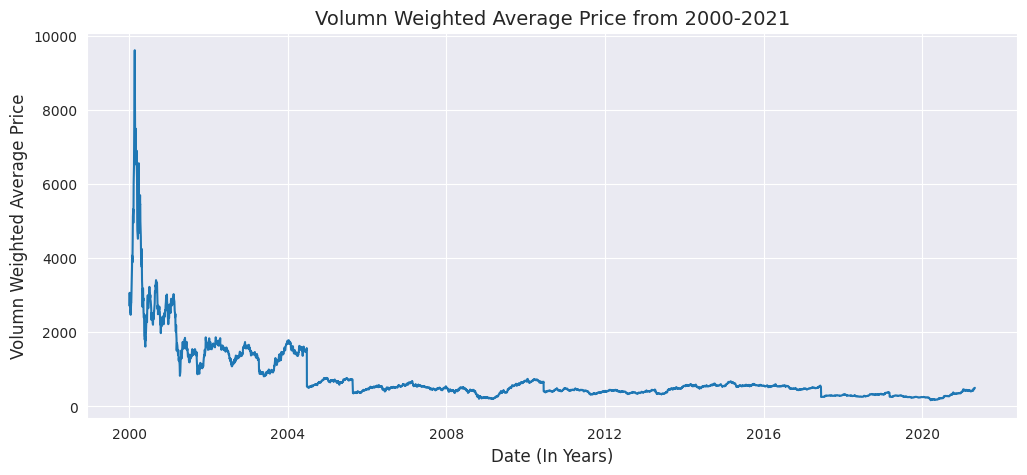

In [10]:
# Since, our objective is to forecast VWAP, let's start with this series
visualize_ts("VWAP",nifty_wipro,"Date",xlabel = "Date (In Years)"
             ,ylabel="Volumn Weighted Average Price",title="Volumn Weighted Average Price from 2000-2021")

From the plot, we can see that there is a tremendous drop in VWAP from `9607.14` (max value in 2000) to just over `501.42` (last recorded observation in the data), which is a decrease of `94.8%`! The sharp rise and subsequent crash in VWAP is also very evident. Let's zoom into various periods for more insights. 

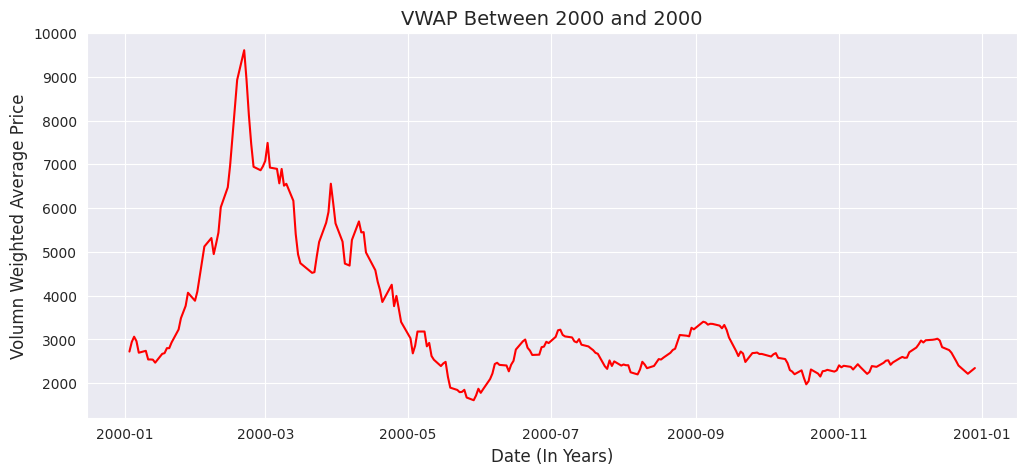

In [11]:
visualize_ts_dates(nifty_wipro,"VWAP","2000","2000",xlabel="Date (In Years)",
                   ylabel="Volumn Weighted Average Price",title="VWAP")

As depicted in the plot, there is a dramatic drop from the Volume Weighted Average Price in 2000 to 2001, subsequently decreasing in the upcoming years. This drop can be attributed to the `dotcom bubble` phenomenon which occured in the stock market in early months of 2000.

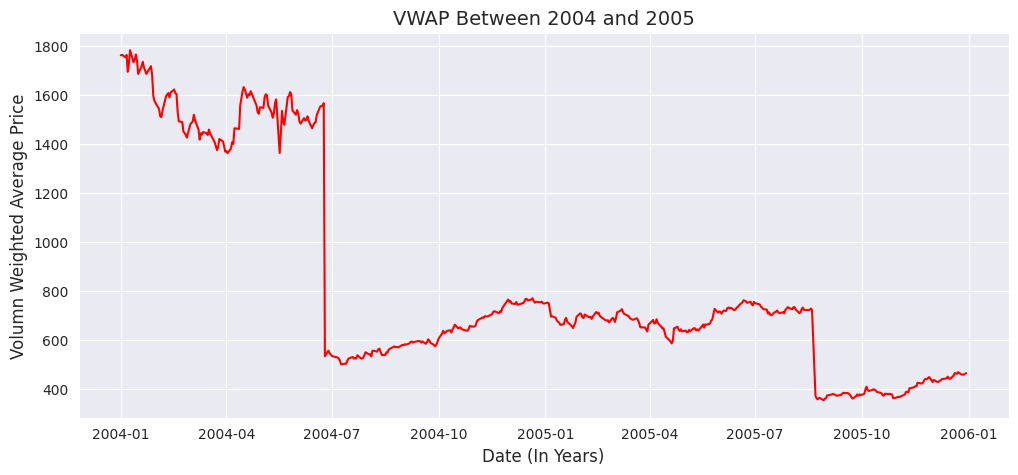

In [12]:
visualize_ts_dates(nifty_wipro,"VWAP","2004","2005",xlabel="Date (In Years)",
                   ylabel="Volumn Weighted Average Price",title="VWAP")

##### Checking Stationarity

From these plots, it seems that the Volume Weighted Average Price column does not have constant variance and mean. This is an important assumption in forecasting a time series and is also known as `stationarity`
`Stationarity` is an assumption in time series forecasting which requires the time series to have a `constant mean` and `constant variance` over time. This means that there is no temporal dependence of mean and vairance with the time series. 

Since we are mentioning mean and variance, we can draw a plot to confirm our observations.

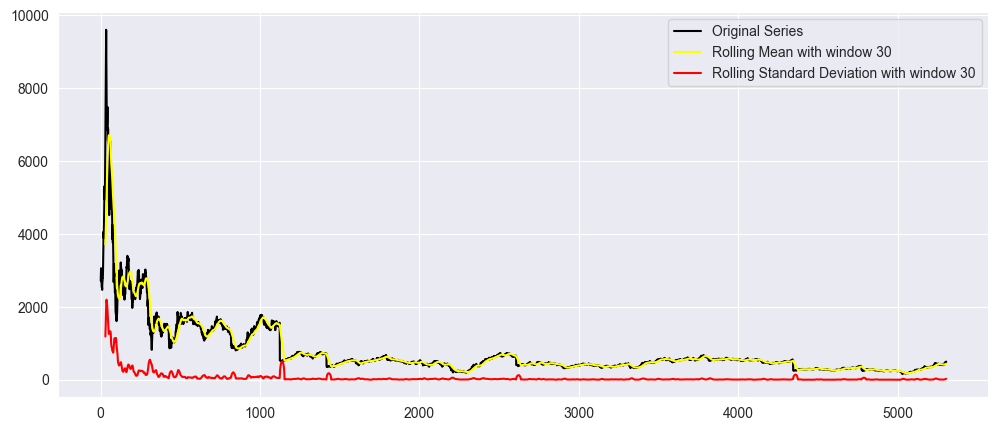

In [13]:
plot_rolling_stats(nifty_wipro,"VWAP",window_size=30)

From the above plot, we can conclude that the assumption of constant mean and constant variance is not followed in the time series. This hints at the non-stationarity of the time series, however, let's run some statistical tests to check for stationarity. 

Some of the well known tests of stationarity are:
1. Augmnted Dickey Fuller Test 
2. KPSS Test 
3. Checking Auto Correlation and Partial Auto Correlation plots.

In [14]:
# Creating a helper function to conduct ADF Test on Time Series 
def adf_test(series):
    print("-------- Augmented-Dickey Fuller Test -------------")
    print()
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'n_lags: {result[1]}')
    print(f'p-value: {result[1]}')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')
    print(f'Result: The series is {"not " if result[1] >= 0.05 else ""}stationary')

# Creating a helper function to conduct KPSS Test on Time Series 
def kpss_test(series):
    print("---------- KPSS Test ---------------")
    print()
    statistic, p_value, n_lags, critical_values = kpss(series)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')
    
# Creating a helper function to plot Auto Correlation and Partial Auto Correlation of Time Series 
def plot_acf_pacf(series):
    with sn.axes_style("darkgrid"):
        fig,(ax1,ax2) = plt.subplots(nrows=2,ncols=1,figsize=(15,10))
        ax1 = plot_acf(series,ax=ax1, title='Autocorrelation Plot')
        ax2 = plot_pacf(series,ax=ax2, title='Partial Autocorrelation Plot')
        
# Helper function to integrate all the above function into a single function
def check_stationarity(series):
    adf_test(series)
    print("\n")
    kpss_test(series)
    plot_acf_pacf(series)
    

In [15]:
# Running ADF Test 
adf_test(nifty_wipro["VWAP"])

-------- Augmented-Dickey Fuller Test -------------

ADF Statistic: -9.623159990277554
n_lags: 1.6877977706367e-16
p-value: 1.6877977706367e-16
Critial Values:
   1%, -3.4315905168068292
   5%, -2.8620881805547453
   10%, -2.5670617960964766
Result: The series is stationary


According to the Augmented Dickey Fuller Test, the time series is stationary. This means that the time series should have constant mean & variance, however, this assumption was disproved in the above cells.

Let's plot the Auto Correlation and Partial Auto Correlation Plots. Autocorelation plots show how correlated are values at time t with the next values in time t+1,t+2,..t+n. If the series is non-stationary, the autocorrelation values will be `highly correlated` with distant points in time showing possible `seasonalities or trends`.

Stationary series autocorrelation values will `quickly decrease over time t`. This shows us that no information is carried over time and then the series should be constant over time.

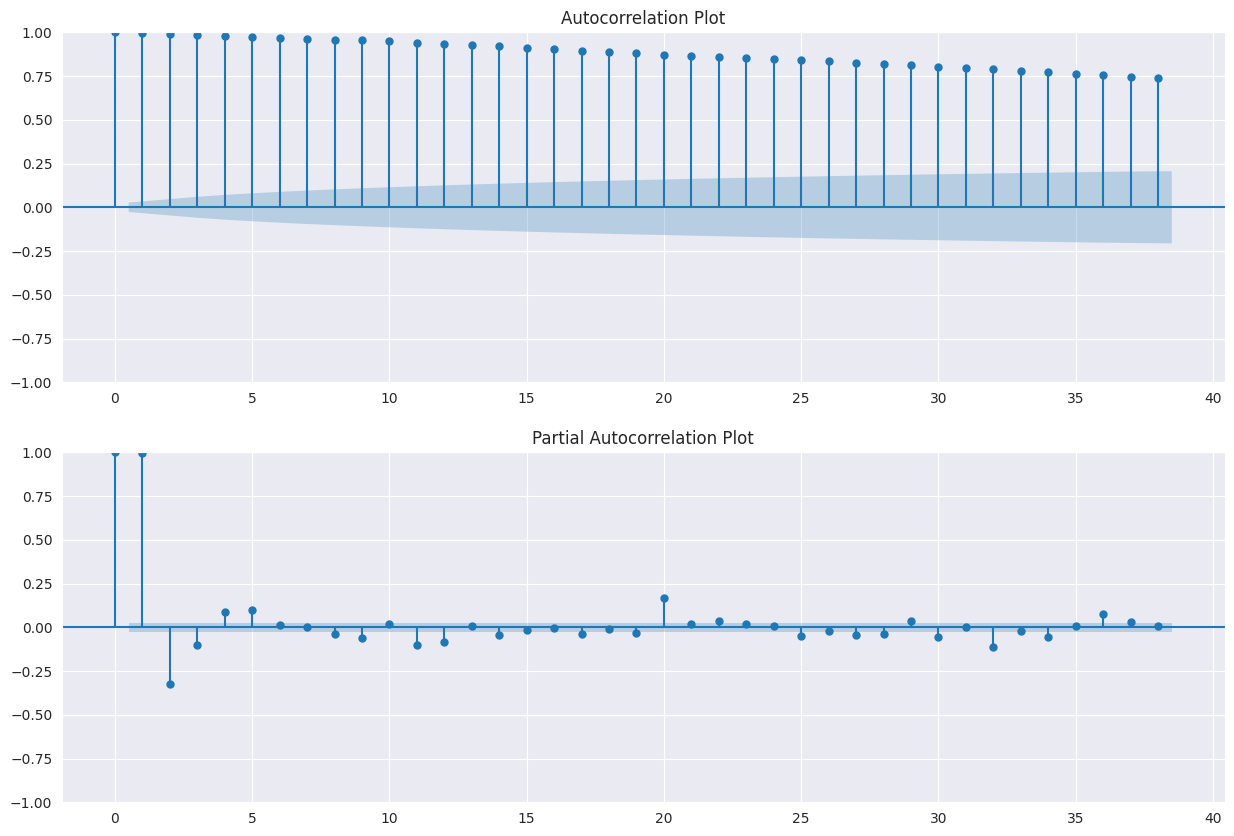

In [16]:
# Plotting ACF & PACF Plots
plot_acf_pacf(nifty_wipro["VWAP"])

In the Auto Correlation Plot, there is high correlation between t and t+1,t+2 and so on. This means that the present values are heavily affected by the past values. This type of observation is not uncommon in the stock market since the value of the stocks 
are somewhat dependant on the value at previous timestamps.

Let's try using the `KPSS-Test`, in order to confirm the Non-Stationarity of the time series.

In [17]:
kpss_test(nifty_wipro["VWAP"])

---------- KPSS Test ---------------

KPSS Statistic: 5.154704289436489
p-value: 0.01
num lags: 43
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


##### Checking Random Walk

Random Walk is a time series behavior model in which the current value of a variable is dependant on the modification of the value of the vairable at t-1 timestep. The value of the variable at the previous time step is added with some random constant, to obtain the value at the current time step.

Identification of Random Walk:
1. Time Series must be Non-Stationarity
2. Gradual Decay in Auto Correlation over lags
3. First Different of the series must be random

From our previous cells, we were able to prove non-stationarity & gradual decay in the autocorrelation in the lags. Let's try verifying the 3rd condition.

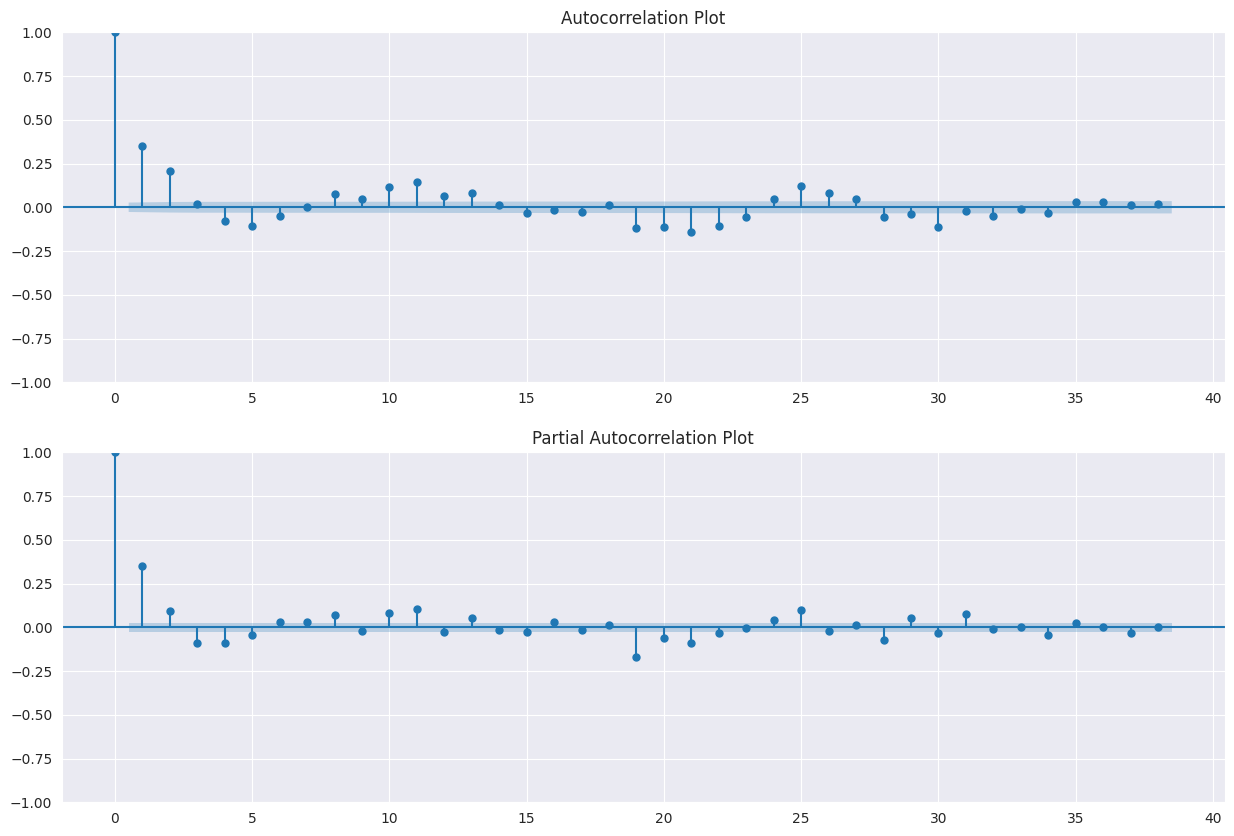

In [18]:
plot_acf_pacf(nifty_wipro["VWAP"].diff().dropna())

The Auto Correlation plot does not show any randomness in the data. Therefore, we ca conclude that the series is not a Random Walk.

##### Seasonal Decomposition